# Data Analysis & Preprocessing

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier


from scipy.stats import f_oneway
import numpy as np

### Carga de dataset

In [69]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=50,ax=ax, facecolor='midnightblue', edgecolor='black')
        title_obj = ax.set_title(var_name+" Distribution")
        plt.setp(title_obj, color='black')                     # Individual title colours.

        # remove grid lines
        ax.grid(False)

        ax.xaxis.label.set_color('black')  
        ax.yaxis.label.set_color('black')          
        ax.tick_params(axis='x', colors='black')       #set the color of xticks
        ax.tick_params(axis='y', colors='black')       #set the color of yticks
        
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

In [70]:
df_full = pd.read_csv("data/fact_application_full.csv")
# df_full

In [71]:
# Se tiene el df con todos los campos disponibles --> 912 aplicaciones
# Seleccionamos solo las aplicaciones que tienen recursos en pdn
df_full_pdn = df_full[df_full['pdnresourcescount'] > 0]
len(df_full_pdn)

682

In [73]:
# Eliminamos las características asociadas a los conteos pues solo vamos a usar la característica con el log
features_a_eliminar = ['provider_id', 'snapshot_date_id',  'applicationcode',  'fullresourcescount',
                       'devresourcescount', 'qaresourcescount', 'pdnresourcescount', 'fullaccountscount',
                       'devaccountscount', 'qaaccountscount', 'pdnaccountscount', 'organization_id',
                       'ppn_tm', 'clasification'
                      ]
df_pdn = df_full_pdn.drop(features_a_eliminar, axis=1)

# Eliminamos application_id ya que es un identificador y no una característica que se deba incluir en el análisis
df_pdn = df_pdn.drop('application_id', axis=1)

features = df_pdn.columns.to_list()
len(features)

25

### Vamos a aplicar PCA a nuestro DF

#### Preprocesamiento


In [74]:
# Estandarización
scaler = StandardScaler()
df_pdn_scaled = scaler.fit_transform(df_pdn)

In [76]:
# Aplicamos PCA
pca = PCA(n_components=10) # Especifica el número de componentes principales a retener
principal_componets = pca.fit_transform(df_pdn_scaled)

print(f"Tipo df_pdn_scaled: {type(df_pdn_scaled)}")
print(f"Tipo principal_componets: {type(principal_componets)}")

Tipo df_pdn_scaled: <class 'numpy.ndarray'>
Tipo principal_componets: <class 'numpy.ndarray'>


In [77]:
# Ahora, principal_components contiene las componentes principales
# Usamos la varianza explicada para determinar cuantos componentes retener

variance_ratio = pca.explained_variance_ratio_
variance_ratio

array([0.17538993, 0.14683006, 0.1193023 , 0.08949586, 0.07953715,
       0.07287354, 0.05732003, 0.05134439, 0.034961  , 0.02522257])

In [80]:
componentes_principales = pca.components_[:3] # Seleccionamos los primeros 3 componentes principales

# Multiplicamos los datos originales por los componentes principales seleccionados
pdn_reducido = df_pdn_scaled.dot(componentes_principales.T)
print(f"Tipo pdn_reducido: {type(pdn_reducido)}")

Tipo pdn_reducido: <class 'numpy.ndarray'>


In [85]:
# Llevamos el pdn_reducido a df
df_pdn_reducido = pd.DataFrame(data=pdn_reducido, columns=['CP1', 'CP2', 'CP3'])
df_pdn_reducido.describe()

,CP1,CP2,CP3
count,6.820000e+02,6.820000e+02,6.820000e+02
mean,-1.699520e-16,-1.289291e-16,-4.069732e-17
std,2.095516e+00,1.917327e+00,1.728276e+00
min,-2.030192e+00,-1.850120e+01,-5.270530e+00
25%,-1.194845e+00,-6.170038e-01,-1.942540e-01
50%,-3.499834e-01,-1.648159e-02,-4.874456e-02
75%,7.200682e-01,6.049999e-01,1.390971e-01
max,2.795853e+01,2.631205e+01,3.202577e+01


C:\Users\2542088\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


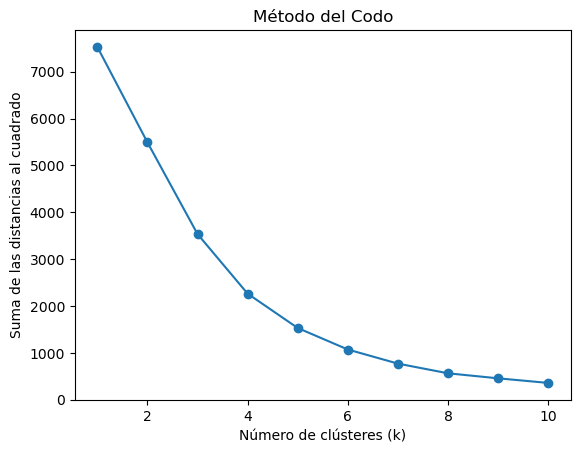

In [94]:
# Utilizamos el método de la "silueta" para determinar el número adecuado de clústers

sum_of_squared_distances = []

# Prueba de diferentes valores de K
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pdn_reducido) # Usnado el ndarray
#     kmeans.fit(df_pdn_reducido) # Usnado el df
    
    sum_of_squared_distances.append(kmeans.inertia_)

# Graficar la suma de las distancias al cuadrado en función de k
plt.plot(range(1, 11),
         sum_of_squared_distances, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de las distancias al cuadrado')
plt.title('Método del Codo')
plt.show()

In [95]:
# Podemos determinar que el número de clúster apropiado puede estar entre 4 y 5
# Seleccionamos k=5

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(df_pdn_reducido)

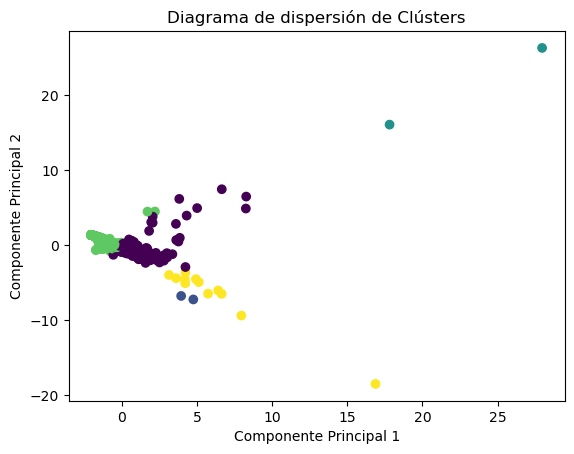

In [101]:
# Ahora visualicemos los clústers
# Usando ndarrary
# x = pdn_reducido[:, 0]
# y = pdn_reducido[:, 1]

# Usando df
x = df_pdn_reducido[['CP1']]
y = df_pdn_reducido[['CP2']]

# Grafiquemos los puntos de datos con colores de acuerdo a sus etiquetas de clúster
plt.scatter(x, y, c=cluster_labels, cmap='viridis')
plt.title('Diagrama de dispersión de Clústers')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [103]:
# Agregamos los cluster al df
df_pdn_reducido['cluster'] = cluster_labels
df_pdn_reducido

,CP1,CP2,CP3,cluster
0,-1.207314,-0.133430,0.106783,3
1,-0.984641,-0.375438,-0.059763,3
2,-0.784317,-0.778926,-0.164896,3
3,-1.434360,0.213013,0.176994,3
4,5.125483,-4.927224,-2.800935,4
...,...,...,...,...
677,-2.030192,1.360245,0.318303,3
678,-1.911982,1.292331,0.295128,3
679,-1.911982,1.292331,0.295128,3
680,-1.911982,1.292331,0.295128,3


In [106]:
# Ahora llevamos nuestros clúster a la data original
df_full_pdn['cluster'] = cluster_labels
df_full_pdn

C:\Users\2542088\AppData\Local\Temp\ipykernel_27964\2825177243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_pdn['cluster'] = cluster_labels


,application_id,organization_id,provider_id,snapshot_date_id,applicationcode,fullresourcescount,devresourcescount,qaresourcescount,pdnresourcescount,fullaccountscount,...,redfaulttolerancedensity,yellowfaulttolerancedensity,redperformancedensity,yellowperformancedensity,redcostoptimizingdensity,yellowcostoptimizingdensity,ppn_tm,pdnresourcessize,clasification,cluster
0,59,1,1,20231021,app00059,29,18,4,7,5,...,0.000,0.000,0.0,0.0,0.0,0.0,2023-10-21 01:04:53.696000,0.845,Red,3
1,625,1,1,20231021,app00625,28,24,1,3,4,...,0.000,0.333,0.0,0.0,0.0,0.0,2023-10-21 01:04:53.696000,0.477,Red,3
2,324,1,1,20231021,app00324,9,1,2,6,3,...,0.000,0.333,0.0,0.0,0.0,0.0,2023-10-21 01:04:53.696000,0.778,Red,3
3,736,1,1,20231021,app00736,6,3,0,3,3,...,0.000,0.000,0.0,0.0,0.0,0.0,2023-10-21 01:04:53.696000,0.477,Red,3
4,785,1,1,20231021,app00785,363,49,163,151,3,...,0.371,0.007,0.0,0.0,0.0,0.0,2023-10-21 01:04:53.696000,2.179,Red,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,216,1,1,20231021,app00216,1,0,0,1,1,...,0.000,0.000,0.0,0.0,0.0,0.0,2023-10-21 01:04:53.696000,0.000,NaN,3
856,217,1,1,20231021,app00217,2,0,0,2,1,...,0.000,0.000,0.0,0.0,0.0,0.0,2023-10-21 01:04:53.696000,0.301,NaN,3
857,420,1,1,20231021,app00420,2,0,0,2,1,...,0.000,0.000,0.0,0.0,0.0,0.0,2023-10-21 01:04:53.696000,0.301,NaN,3
858,748,1,1,20231021,app00748,6,2,2,2,3,...,0.000,0.000,0.0,0.0,0.0,0.0,2023-10-21 01:04:53.696000,0.301,NaN,3
